# 0. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.features import Rank2D, FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
import streamlit as st

In [2]:
df = pd.read_csv("/Users/vasiliskalyvas/Library/CloudStorage/OneDrive-Προσωπικό/python projects/public_cars.csv")
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,...,False,False,False,False,False,False,False,False,7,4250.0
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,...,False,False,False,False,False,False,False,False,133,4000.0
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,...,False,True,False,False,True,True,True,True,0,10900.0
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,...,True,False,False,True,False,False,True,True,20,6999.0
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,...,False,False,False,False,False,False,False,True,160,1600.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30824 entries, 0 to 30823
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  30824 non-null  object 
 1   model_name         30824 non-null  object 
 2   transmission       30824 non-null  object 
 3   color              30824 non-null  object 
 4   odometer_value     30824 non-null  int64  
 5   year_produced      30824 non-null  int64  
 6   engine_fuel        30824 non-null  object 
 7   engine_has_gas     30824 non-null  bool   
 8   engine_type        30824 non-null  object 
 9   engine_capacity    30816 non-null  float64
 10  body_type          30824 non-null  object 
 11  has_warranty       30824 non-null  bool   
 12  state              30824 non-null  object 
 13  drivetrain         30824 non-null  object 
 14  feature_0          30824 non-null  bool   
 15  feature_1          30824 non-null  bool   
 16  feature_2          308

# 1. Distribution Test

<AxesSubplot:>

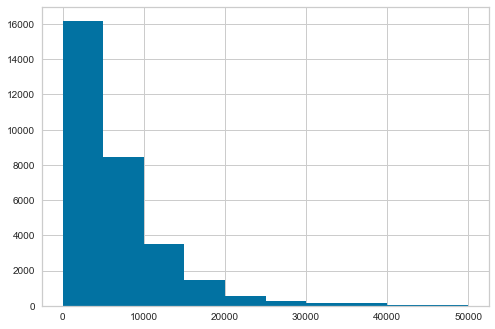

In [4]:
df.price_usd.hist()

In [5]:
# This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
normaltest(df.price_usd.values)

NormaltestResult(statistic=14747.843370532468, pvalue=0.0)

p-value _extremely_ low. That means distribution of price is not normally distributed.

Linear Regression assumes a normally distributed residuals which can be **aided** by transforming y variable. Let's try some common transformations to try and get y to be normally distributed: 

* Log
* Square root
* Box cox

Log:
NormaltestResult(statistic=1476.7140297245905, pvalue=0.0)


Square Root:
NormaltestResult(statistic=3057.3840527927478, pvalue=0.0)


Boxcox: 
NormaltestResult(statistic=170.356343293092, pvalue=1.0176304069833364e-37)


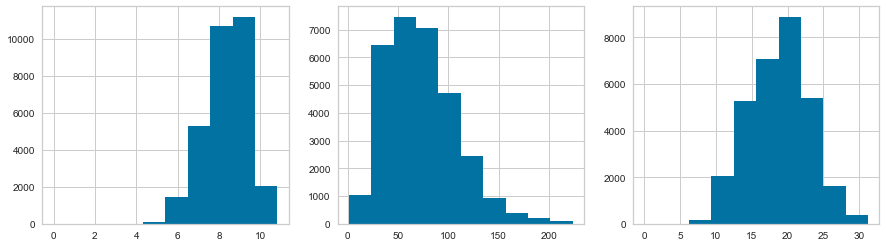

In [6]:
plt.figure(figsize=(15,4))

# log
log_price = np.log(df['price_usd'])
plt.subplot(1,3,1)
plt.hist(log_price)
print('Log:')
print(normaltest(log_price.values))
print('\n')

# Sqrt
sqrt_price = np.sqrt(df.price_usd)
plt.subplot(1,3,2)
plt.hist(sqrt_price)
print('Square Root:')
print(normaltest(sqrt_price.values))
print('\n')

# Boxcox
from scipy.stats import boxcox
bc_result = boxcox(df.price_usd)
boxcox_price = bc_result[0]
lam = bc_result[1]
plt.subplot(1,3,3)
plt.hist(boxcox_price)
print('Boxcox: ')
print(normaltest(pd.Series(boxcox_price).values))

# 2. EDA

In [7]:
# remove unecessary/unknown features
df = df.drop(['feature_0','feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9'], axis=1)

In [8]:
# look for Nulls in any feature
pd.isna(df).sum()

#  there are few Nulls only in engine_capacity, we can remove those rows entirely

manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      8
body_type            0
has_warranty         0
state                0
drivetrain           0
duration_listed      0
price_usd            0
dtype: int64

In [9]:
# remove rows where engine_capacity is Null
df = df[pd.isna(df['engine_capacity'])==False]
df.reset_index(drop=True, inplace=True)

2023-03-08 01:20:59.049 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [10]:
df.describe(include='all')

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,duration_listed,price_usd
count,30816,30816,30816,30816,30816.000000,30816.000000,30816,30816,30816,30816.000000,30816,30816,30816,30816,30816.000000,30816.000000
unique,55,1068,2,12,NaN,NaN,5,2,2,NaN,12,2,3,3,NaN,NaN
top,Volkswagen,Passat,mechanical,black,NaN,NaN,gasoline,False,gasoline,NaN,sedan,False,owned,front,NaN,NaN
freq,3406,1153,20493,6160,NaN,NaN,19259,29746,20511,NaN,10433,30449,30146,22187,NaN,NaN
mean,NaN,NaN,NaN,NaN,248848.781315,2002.936754,NaN,NaN,NaN,2.054232,NaN,NaN,NaN,NaN,80.352836,6627.403698
std,NaN,NaN,NaN,NaN,135747.228412,8.047727,NaN,NaN,NaN,0.667535,NaN,NaN,NaN,NaN,112.668309,6408.444285
min,NaN,NaN,NaN,NaN,0.000000,1950.000000,NaN,NaN,NaN,0.200000,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,158500.000000,1998.000000,NaN,NaN,NaN,1.600000,NaN,NaN,NaN,NaN,23.000000,2134.120000
50%,NaN,NaN,NaN,NaN,250000.000000,2003.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,59.000000,4800.000000
75%,NaN,NaN,NaN,NaN,325000.000000,2009.000000,NaN,NaN,NaN,2.300000,NaN,NaN,NaN,NaN,91.000000,8950.000000


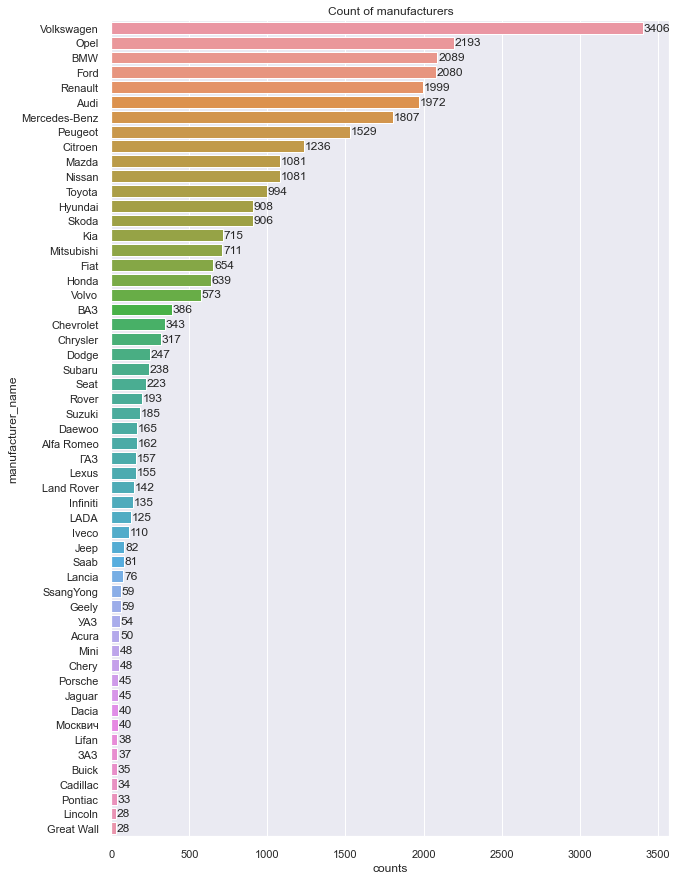

In [11]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='manufacturer_name').size().reset_index(name="counts").sort_values('counts', ascending=False), 
              y='manufacturer_name', x='counts')
ax.set(title="Count of manufacturers") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# Volkswagen is by far the top manufacturer among total 55 companies, in terms of numbers of cars in this dataset.

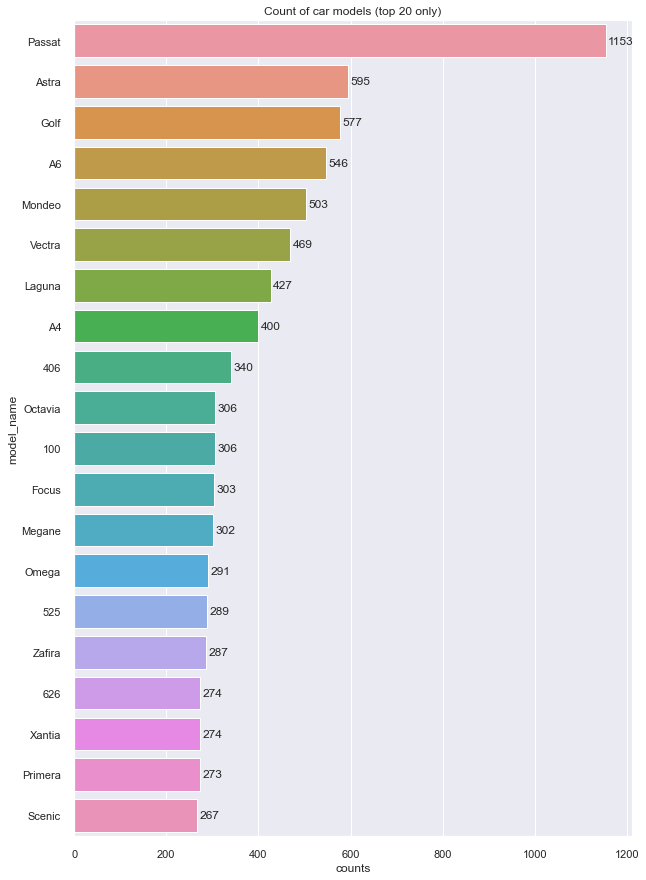

In [12]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='model_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(20), 
              y='model_name', x='counts')
ax.set(title="Count of car models (top 20 only)") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# Volkswagen is mainly represented by Passat and Golf, whereas Opel from Astra and Vectra.

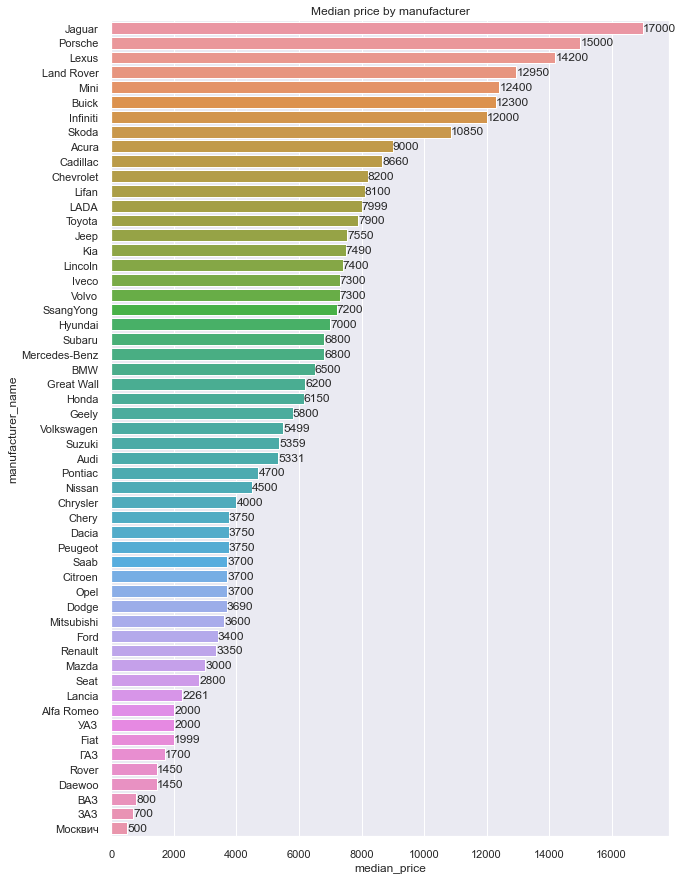

In [13]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='manufacturer_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False), 
              y='manufacturer_name', x='median_price')
ax.set(title="Median price by manufacturer") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# This plot is more informative, because it creates a distinction between expensive and more affordable manufacturers based on the median price (more robust metric to outliers than mean).

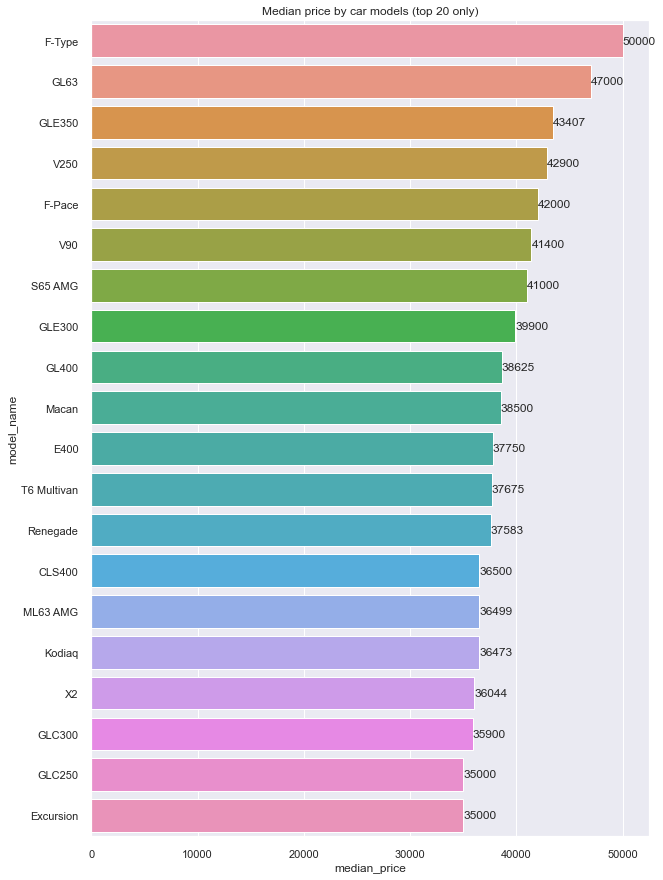

In [14]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='model_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(20), 
              y='model_name', x='median_price')
ax.set(title="Median price by car models (top 20 only)") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# The 20 most expensive models.

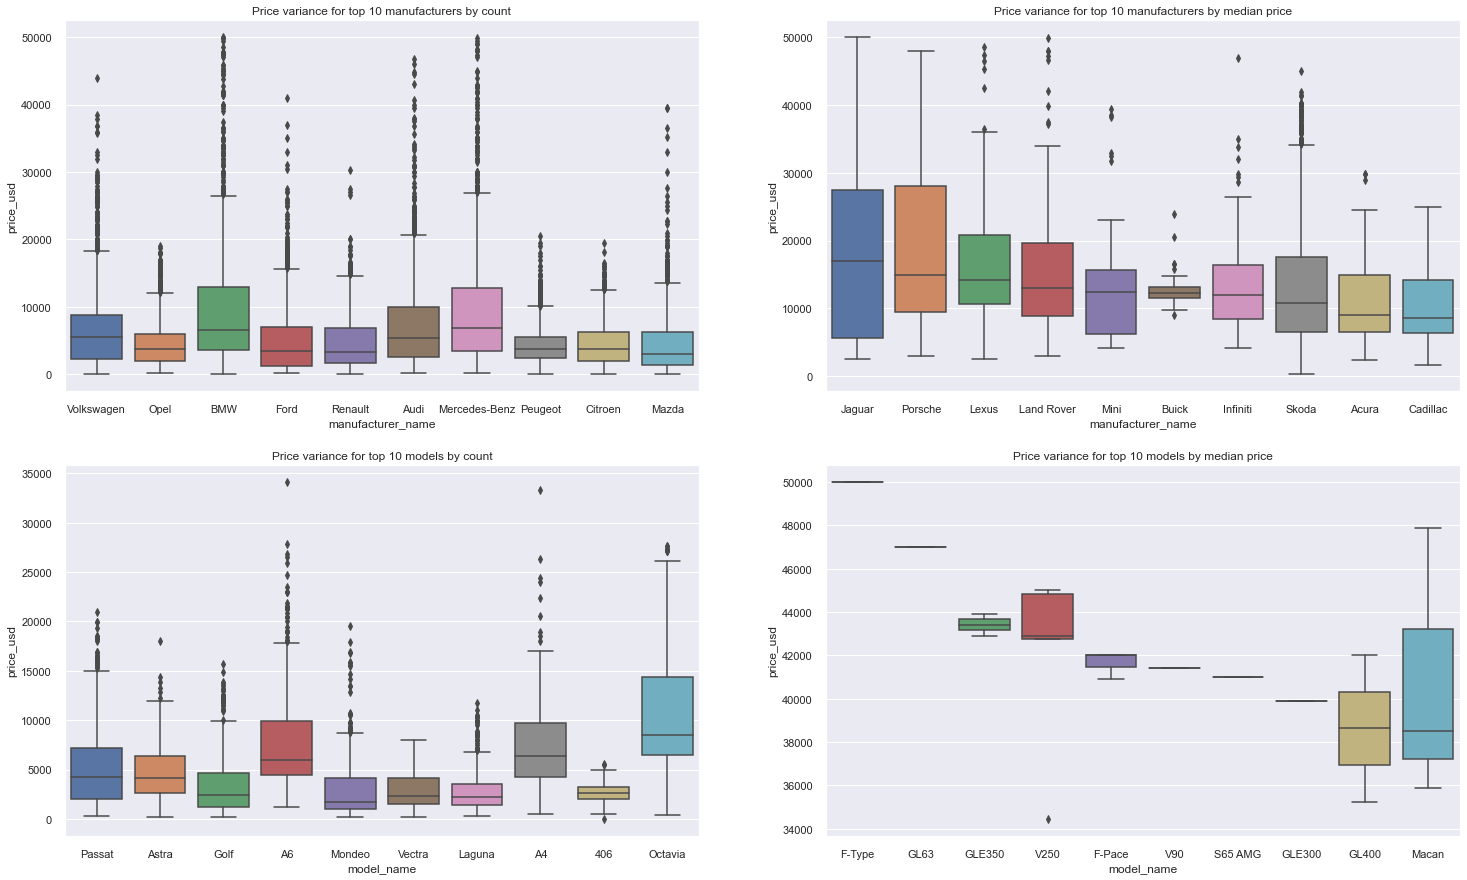

In [15]:
# top 10 brands by count and by median price
top_10_brands_in_count = list(df.groupby(by='manufacturer_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(10)['manufacturer_name'])
df_top_10_brands_in_count = df[df['manufacturer_name'].isin(top_10_brands_in_count)]

top_10_brands_in_median_price = list(df.groupby(by='manufacturer_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10)['manufacturer_name'])
df_top_10_brands_in_median_price = df[df['manufacturer_name'].isin(top_10_brands_in_median_price)]


# top 10 models by count and by median price
top_10_models_in_count = list(df.groupby(by='model_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(10)['model_name'])
df_top_10_models_in_count = df[df['model_name'].isin(top_10_models_in_count)]

top_10_models_in_median_price = list(df.groupby(by='model_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10)['model_name'])
df_top_10_models_in_median_price = df[df['model_name'].isin(top_10_models_in_median_price)]


# plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))

sns.boxplot(data=df_top_10_brands_in_count, x='manufacturer_name', y='price_usd', ax=axs[0][0], order=top_10_brands_in_count)
axs[0][0].set(title='Price variance for top 10 manufacturers by count')
sns.boxplot(data=df_top_10_brands_in_median_price, x='manufacturer_name', y='price_usd', ax=axs[0][1], order=top_10_brands_in_median_price)
axs[0][1].set(title='Price variance for top 10 manufacturers by median price')

sns.boxplot(data=df_top_10_models_in_count, x='model_name', y='price_usd', ax=axs[1][0], order=top_10_models_in_count)
axs[1][0].set(title='Price variance for top 10 models by count')
sns.boxplot(data=df_top_10_models_in_median_price, x='model_name', y='price_usd', ax=axs[1][1], order=top_10_models_in_median_price)
axs[1][1].set(title='Price variance for top 10 models by median price')

print('')

#### Insights: 
# The most popular manufacturers (most counts in the dataset) have less variance in the price than the most expensive ones but have more outliers
# This may be because brands that are mostly expensive have fewer models in the dataset and their prices can more easily be affected by other variables (even variables outside of this dataset, like the "brand name").
# For example, someone who wants to add an Opel car in the dataset might think that the price should be around 4,000 - 5,000 to be competitive against the other cars (either from Opel or not).
# However, when adding a Jaguar there is not muh competition and the price can vary a lot, depending on transmission, state, warranty, engine etc and can reach high levels (it is a Jaguar after all!)
# Same thing happens with models.

#### So: most popular cars (either in terms of manufacturer or model) tend to be more stable in their price ranges.

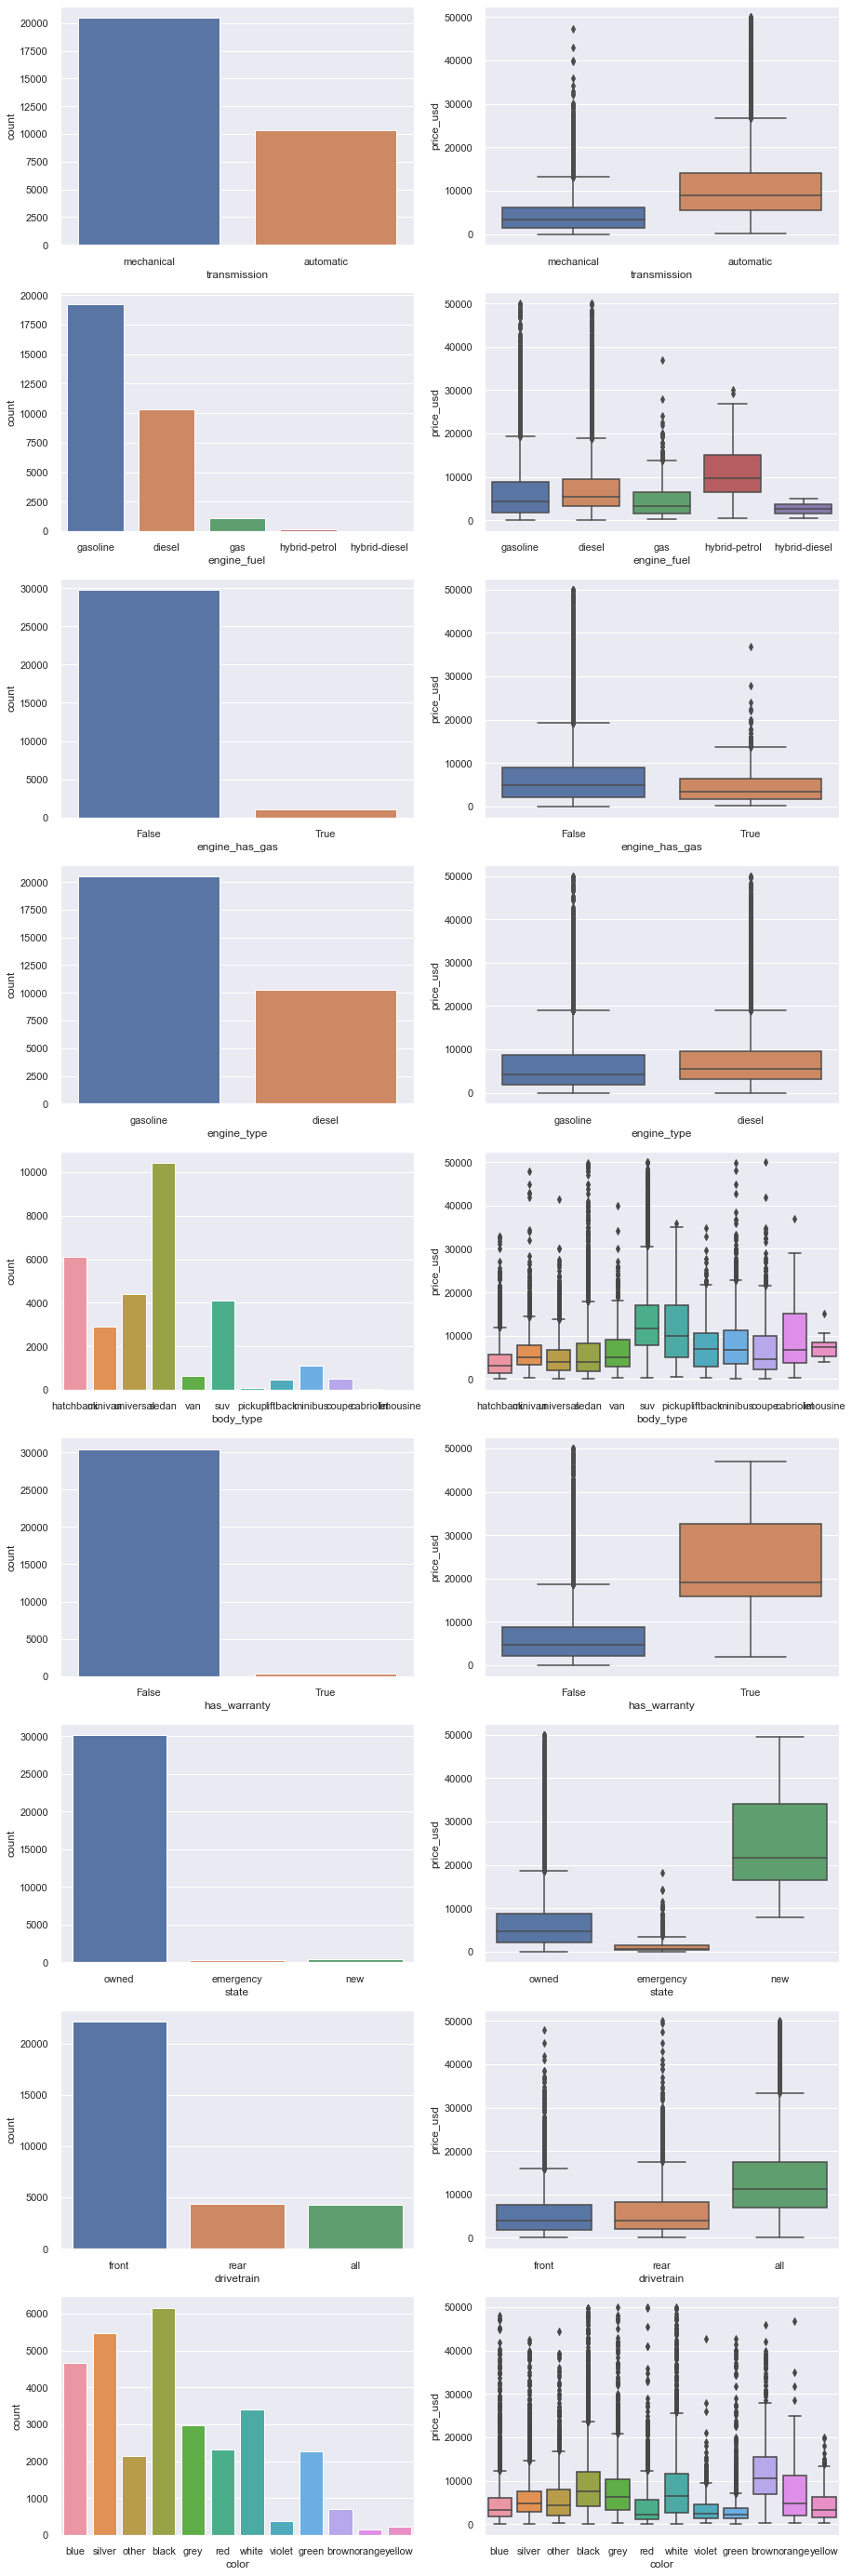

In [16]:
# Plot the categorical variables, both on their own (on the left) and against price (on the right):

fig, axs = plt.subplots(nrows=9, ncols=2, figsize=(15,50))

sns.countplot(data=df, x='transmission', ax=axs[0][0])
sns.boxplot(data=df, x='transmission', y='price_usd', ax=axs[0][1])

sns.countplot(data=df, x='engine_fuel', ax=axs[1][0])
sns.boxplot(data=df, x='engine_fuel', y='price_usd', ax=axs[1][1])

sns.countplot(data=df, x='engine_has_gas', ax=axs[2][0])
sns.boxplot(data=df, x='engine_has_gas', y='price_usd', ax=axs[2][1])

sns.countplot(data=df, x='engine_type', ax=axs[3][0])
sns.boxplot(data=df, x='engine_type', y='price_usd', ax=axs[3][1])

sns.countplot(data=df, x='body_type', ax=axs[4][0])
sns.boxplot(data=df, x='body_type', y='price_usd', ax=axs[4][1])

sns.countplot(data=df, x='has_warranty', ax=axs[5][0])
sns.boxplot(data=df, x='has_warranty', y='price_usd', ax=axs[5][1])

sns.countplot(data=df, x='state', ax=axs[6][0])
sns.boxplot(data=df, x='state', y='price_usd', ax=axs[6][1])

sns.countplot(data=df, x='drivetrain', ax=axs[7][0])
sns.boxplot(data=df, x='drivetrain', y='price_usd', ax=axs[7][1])

sns.countplot(data=df, x='color', ax=axs[8][0])
sns.boxplot(data=df, x='color', y='price_usd', ax=axs[8][1])

print('')

#### Insights:
# -> mechanical cars are double the automatics, however automatics are more expensive (double the price)
# -> sedans and front-drive cars are the most popular, but not most expensive
# -> the engine type and engine fuel is mostly gasoline, but hybrid-petrol the most expensive
# -> vast majority owned and without warranty, but new with guarantee can lead to sigificantly high prices
# -> black and silver the most popular, but brown cars have the highest median price

#### So, it seems that high prices can be related to automatic cars with hybrid-petrol fuel, that 
#### are new and have warranty.

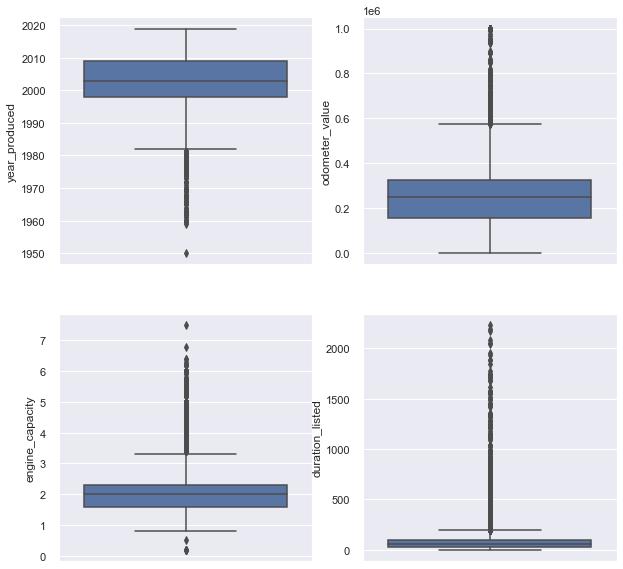

In [17]:
# Plot the numerical variables, on their own:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.boxplot(data=df, y='year_produced', ax=axs[0][0])
sns.boxplot(data=df, y='odometer_value', ax=axs[0][1])
sns.boxplot(data=df, y='engine_capacity', ax=axs[1][0])
sns.boxplot(data=df, y='duration_listed', ax=axs[1][1])
print('')

#### Insights:
# -> cars mostly produced around 2002, with avg odometer value of 250K km
# -> mainly with 2 engines, being listed mostly under 100 days

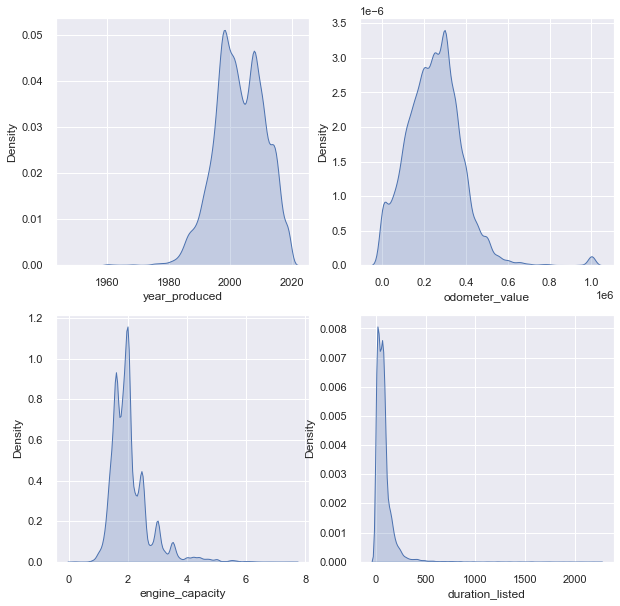

In [18]:
# Plot distribution of numerical variables:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.kdeplot(df.year_produced, ax=axs[0][0], shade=True)
sns.kdeplot(df.odometer_value, ax=axs[0][1], shade=True)
sns.kdeplot(df.engine_capacity, ax=axs[1][0], shade=True)
sns.kdeplot(df.duration_listed, ax=axs[1][1], shade=True)

print('')

#### Insights:
# -> no normal distribution in any numerical variable

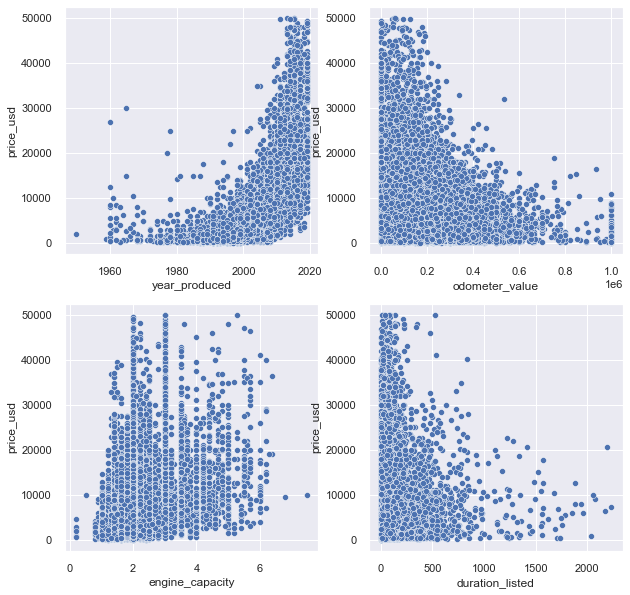

In [19]:
# Plot the relationship between target and numerical variables

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.scatterplot(data=df, x='year_produced',   y='price_usd', ax=axs[0][0])
sns.scatterplot(data=df, x='odometer_value',  y='price_usd', ax=axs[0][1])
sns.scatterplot(data=df, x='engine_capacity', y='price_usd', ax=axs[1][0])
sns.scatterplot(data=df, x='duration_listed', y='price_usd', ax=axs[1][1])

print('')

#### Insights:
# -> no clear linear relationship
# -> year and odometer_value seem to be the most correlated to price

# 3. Statistical testing

In [20]:
# these are dataframes
df_numericals = df.select_dtypes(['int64','float64'])
df_categoricals = df.select_dtypes(['object','bool'])

# these are lists
numericals = [i for i in df_numericals.columns]
categoricals = [i for i in df_categoricals.columns]

print('numericals: ', numericals)
print('categoricals: ', categoricals)

numericals:  ['odometer_value', 'year_produced', 'engine_capacity', 'duration_listed', 'price_usd']
categoricals:  ['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain']


## 3a) numerical target - numerical features: pearson's correlation coefficient

<AxesSubplot:>

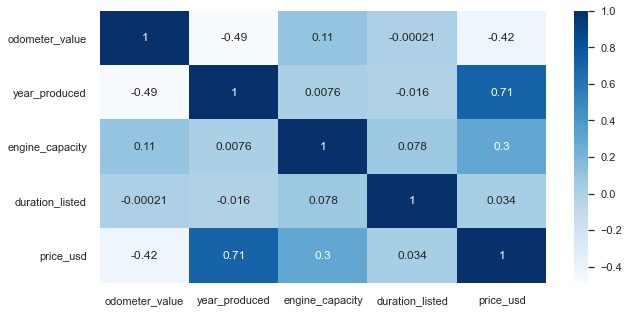

In [21]:
plt.figure(figsize=(10,5))
sns.heatmap(df_numericals.corr(), annot=True, cmap='Blues')

In [22]:
# Keep only "year_produced" and "odometer_value" (remove the other numerical features)
# (those two seem to be mostly related to price_usd, both from heatmap and plots)
df_numericals = df_numericals[['year_produced', 'odometer_value', 'price_usd']]

## 3b) categorical target - numerical features: ANOVA test

In [23]:
# See how many values every categorical feature has:

for i in df_categoricals:
    print(i, ':', df_categoricals[i].nunique())

manufacturer_name : 55
model_name : 1068
transmission : 2
color : 12
engine_fuel : 5
engine_has_gas : 2
engine_type : 2
body_type : 12
has_warranty : 2
state : 3
drivetrain : 3


In [24]:
# Define ANOVA test (for a categorical feature against a numerical target)

def anova(df, feature):
    model_ols = ols('price_usd ~ {}'.format(feature), data=df).fit()
    anova_table = anova_lm(model_ols, typ=2)
    return anova_table

In [25]:
# Test for statistical importance of categoricals

anova_for_categoricals = []
for i in categoricals:
    anova_for_categoricals.append([i,anova(df, i).loc[i,'PR(>F)']])

anova_for_categoricals = pd.DataFrame(anova_for_categoricals, columns=['feature','anova pvalue'])
anova_for_categoricals.columns = [str(column) for column in anova_for_categoricals.columns]
anova_for_categoricals

# All pvalues < 0.05, so keep them all.

,feature,anova pvalue
0,manufacturer_name,0.000000e+00
1,model_name,0.000000e+00
2,transmission,0.000000e+00
3,color,0.000000e+00
4,engine_fuel,1.236189e-92
5,engine_has_gas,4.502468e-28
6,engine_type,2.527997e-55
7,body_type,0.000000e+00
8,has_warranty,0.000000e+00
9,state,0.000000e+00


## 3c) final remaining features

In [26]:
# Convert "object" type to "category" type, for the ML model later.

for feature in categoricals:
    df_categoricals[feature] = pd.Series(df_categoricals[feature], dtype="category")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# Combine again all remaining features and the target:

df_remaining = df_categoricals.join(df_numericals)
df_remaining

,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,year_produced,odometer_value,price_usd
0,Ford,Fusion,mechanical,blue,gasoline,False,gasoline,hatchback,False,owned,front,2006,245000,4250.0
1,Dodge,Caravan,automatic,silver,gasoline,False,gasoline,minivan,False,owned,front,2002,265542,4000.0
2,Ford,Galaxy,mechanical,blue,diesel,False,diesel,minivan,False,owned,front,2009,168000,10900.0
3,Mazda,6,mechanical,other,gasoline,False,gasoline,universal,False,owned,front,2008,225522,6999.0
4,Audi,80,mechanical,black,gasoline,False,gasoline,sedan,False,owned,front,1991,370000,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30811,Mazda,Millenia,automatic,green,gasoline,False,gasoline,sedan,False,owned,front,1999,360493,2000.0
30812,Audi,A3,automatic,grey,gasoline,False,gasoline,universal,False,owned,front,2009,117000,8800.0
30813,Mazda,626,mechanical,black,gasoline,False,gasoline,hatchback,False,owned,front,1997,333000,1400.0
30814,Audi,A6,automatic,violet,gasoline,False,gasoline,universal,False,owned,all,1995,530000,3500.0


# 4. Define Regression Metrics

In [28]:
# Define MAE and RMSE for regression

def evaluate_predictions(true, predictions):
    mae = np.mean(abs(true - predictions))
    rmse = np.sqrt(np.mean((true - predictions) ** 2))  # or: np.sqrt(mean_squared_error(ytrue, ypredicted))
    return mae, rmse

# 5. Train Model

## 5a) Modelling

In [29]:
# Separate independent features from target:

X = df_remaining.drop(['price_usd'], axis=1)
y = df_remaining['price_usd']


# Define the train and test datasets for both features and target:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Define the LGBM regressor with default hyperparameters and by specifying 
# the categorical features (to be handled differently by the model):

lgbm = lightgbm.LGBMRegressor(categorical_feature=[0,1,2,3,4,5,6,7,8,9,10], n_jobs=-1)


# Fit on train, predict on test and calculate metrics:

lgbm.fit(X_train, y_train)

y_preds = lgbm.predict(X_test)

lgbm_mae, lgbm_rmse = evaluate_predictions(y_test, y_preds)
lgbm_r2 = r2_score(y_test, y_preds)

print('LightGBM MAE: ', round(lgbm_mae,2))
print('LightGBM RMSE: ', round(lgbm_rmse,2))
print('LightGBM R2: ', round(lgbm_r2,4))

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


LightGBM MAE:  1043.16
LightGBM RMSE:  1885.97
LightGBM R2:  0.9166


In [31]:
# Naive baseline is the median

median_pred = y_train.median()
median_preds = [median_pred for _ in range(len(y_test))]

baseline_mae, baseline_rmse = evaluate_predictions(median_preds, y_test)
print('Baseline MAE: ', round(baseline_mae,2))
print('Baseline RMSE: ', round(baseline_rmse,2))

Baseline MAE:  4378.6
Baseline RMSE:  6795.14


## Our model predicts a lot better than just the median. It decreases both errors by around 75%!

## 5b) Diagnostics Plots

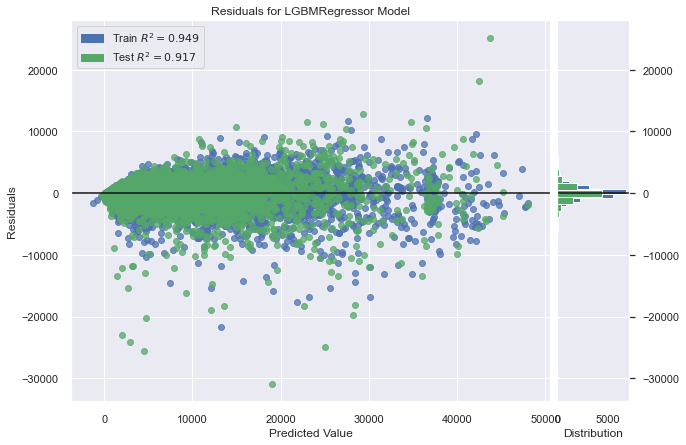

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [32]:
fig = plt.figure(figsize=(10,7))
resid_plot = ResidualsPlot(lgbm)

resid_plot.fit(X_train, y_train)  # Fit the training data to the visualizer
resid_plot.score(X_test, y_test)  # Evaluate the model on the test data
resid_plot.show()                 # Finalize and render the figure

# There are larger errors for the smaller-price predictions in the test set.
# Also, train and test R2 are quite similar, so no important trouble of overfitting.

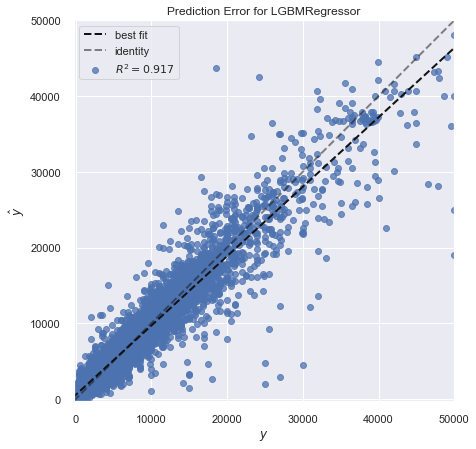

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [33]:
fig = plt.figure(figsize=(10,7))
pred_error = PredictionError(lgbm)

pred_error.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_error.score(X_test, y_test)  # Evaluate the model on the test data
pred_error.show()                 # Finalize and render the figure

# The fit diagonal (actuals VS predictions) is almost on top of the pure diagonal, that means 
# a very  good fit.
# There are more datapoints under the diagonal, that means the model tends to underestimate 
# in general (both expensive and cheaper cars).

## 5c) Find Optimal Hyperparameters with GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[50, 100, 150, 200], 
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5], 
          'num_leaves':[10, 50, 100, 200],
          'max_depth':[-1]}


gscv = GridSearchCV(lgbm, params, n_jobs=-1)
gscv.fit(X_train, y_train)

lgbm_cv = gscv.best_estimator_
print(lgbm_cv)

y_preds_lgbm_cv = lgbm_cv.predict(X_test)

lgbm_cv_mae, lgbm_cv_rmse = evaluate_predictions(y_test, y_preds_lgbm_cv)
lgbm_cv_r2 = r2_score(y_test, y_preds_lgbm_cv)

print('LightGBM MAE with CV: ', round(lgbm_cv_mae,2))
print('LightGBM RMSE with CV: ', round(lgbm_cv_rmse,2))
print('LightGBM R2 with CV: ', round(lgbm_cv_r2,4))

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


LGBMRegressor(categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              n_estimators=200, num_leaves=50)
LightGBM MAE with CV:  1018.19
LightGBM RMSE with CV:  1846.87
LightGBM R2 with CV:  0.92


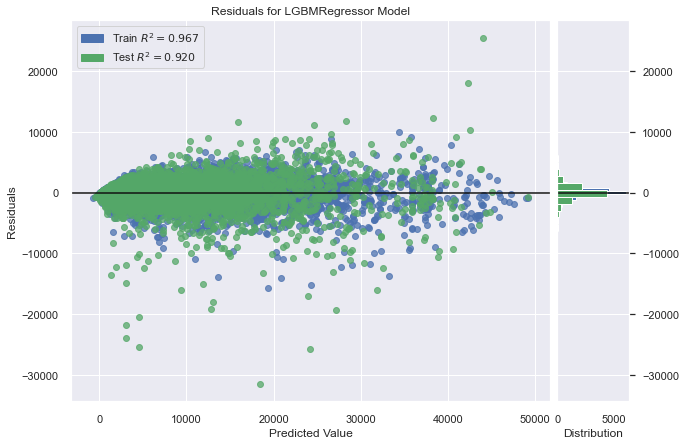

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
fig = plt.figure(figsize=(10,7))
resid_plot = ResidualsPlot(lgbm_cv)

resid_plot.fit(X_train, y_train)  # Fit the training data to the visualizer
resid_plot.score(X_test, y_test)  # Evaluate the model on the test data
resid_plot.show()                 # Finalize and render the figure

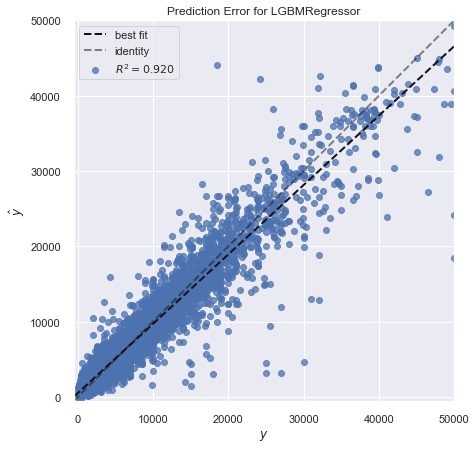

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [36]:
fig = plt.figure(figsize=(10,7))
pred_error = PredictionError(lgbm_cv)

pred_error.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_error.score(X_test, y_test)  # Evaluate the model on the test data
pred_error.show()                 # Finalize and render the figure

# there are larger errors for more expensive cars

## A little better performance but still not improved the underestimation and larger error in smaller-price predictions (in the test set)..

## 5d) Quick Investigation on greatest errors

In [37]:
X_test_with_y = X_test.copy()
X_test_with_y['y_preds'] = y_preds_lgbm_cv
X_test_with_y['y_true'] = y_test
X_test_with_y['error'] = X_test_with_y['y_preds'] - X_test_with_y['y_true']
X_test_with_y['abs_error'] = abs(X_test_with_y['error'])
X_test_with_y.reset_index(drop=True, inplace=True)

In [38]:
greatest_errors_df = X_test_with_y[X_test_with_y['abs_error']>=10000].sort_values(by='abs_error', ascending=False)
greatest_errors_df

,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,year_produced,odometer_value,y_preds,y_true,error,abs_error
5645,Chevrolet,Express,automatic,black,gasoline,False,gasoline,minibus,False,owned,all,2011,64500,18466.947235,49900.00,-31433.052765,31433.052765
7574,Jaguar,F-Type,automatic,red,gasoline,False,gasoline,coupe,False,owned,rear,2013,64075,24190.044892,50000.00,-25809.955108,25809.955108
5270,Mercedes-Benz,Sprinter,automatic,white,diesel,False,diesel,minibus,False,owned,all,2017,30000,43998.760692,18500.00,25498.760692,25498.760692
8075,ГАЗ,21,mechanical,black,gasoline,False,gasoline,sedan,False,owned,rear,1965,8500,4608.822946,30000.00,-25391.177054,25391.177054
7792,ГАЗ,М20,mechanical,brown,gasoline,False,gasoline,sedan,False,owned,rear,1960,45000,3120.030609,27000.00,-23879.969391,23879.969391
8271,ГАЗ,24,mechanical,other,gasoline,False,gasoline,sedan,False,owned,rear,1978,300,3135.850898,25000.00,-21864.149102,21864.149102
679,Mercedes-Benz,S500,automatic,blue,gasoline,False,gasoline,sedan,False,owned,front,1997,190000,4523.248805,25000.00,-20476.751195,20476.751195
3284,Lexus,LX,automatic,black,gasoline,False,gasoline,suv,False,owned,all,2013,167000,27150.002596,46500.00,-19349.997404,19349.997404
2315,Mercedes-Benz,Sprinter,mechanical,white,diesel,False,diesel,minibus,False,owned,rear,2009,535000,12828.814211,32000.00,-19171.185789,19171.185789
5554,BMW,X5,automatic,black,diesel,False,diesel,suv,False,owned,all,2015,134742,42259.040428,24212.93,18046.110428,18046.110428


## All of the cases that the model underestimates do not have gas, do not have warranty and are previously owned. These are features that usually bring the price down, so they must have overtaken the other features (e.g. mostly expensive brands).
## Also, we see older cars but with small odometer values. In these cases, the very old age must have brought the price down taking the other features into account, too (e.g. mechanical)

In [39]:
# Let's log the price (to make it more like normal) and find the optimal model with GridSearchCV:

lgbmlog = lightgbm.LGBMRegressor(categorical_feature=[0,1,2,3,4,5,6,7,8,9,10], n_jobs=-1)
y_train_log = np.log(y_train+0.0001)  # add a constant, although for this dataset we won't have any 0 values

params = {'n_estimators':[50, 100, 150, 200], 
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5], 
          'num_leaves':[10, 50, 100, 200],
          'max_depth':[-1]}

gscv_log = GridSearchCV(lgbmlog, params, n_jobs=-1)
gscv_log.fit(X_train, y_train_log)

lgbm_log = gscv_log.best_estimator_

# these will be logged predictions:
y_preds_logged = lgbm_log.predict(X_test)

# inverse-transofrm the predictions, to bring them to real units (as the original target)
y_preds_unlogged = np.exp(y_preds_logged)-0.0001

# calculate the new metrics:
lgbm_mae_unlogged, lgbm_rmse_unlogged = evaluate_predictions(y_test, y_preds_unlogged)
lgbm_r2_unlogged = r2_score(y_test, y_preds_unlogged)

print('LightGBM_unlogged MAE: ', round(lgbm_mae_unlogged,2))
print('LightGBM_unlogged RMSE: ', round(lgbm_rmse_unlogged,2))
print('LightBM_unlogged R2: ', round(lgbm_r2_unlogged,4))

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


LightGBM_unlogged MAE:  1037.65
LightGBM_unlogged RMSE:  1945.18
LightBM_unlogged R2:  0.9113


## Not much of an improvement.
## Now see the predictions with the log model on the previous greatest errors:

In [40]:
X_test_with_y['y_preds_log_model'] = y_preds_unlogged
X_test_with_y['error_log_model'] = X_test_with_y['y_preds_log_model'] - X_test_with_y['y_true']
X_test_with_y['abs_error_log_model'] = abs(X_test_with_y['error_log_model'])
X_test_with_y.reset_index(drop=True, inplace=True)

greatest_errors_df = X_test_with_y[X_test_with_y['abs_error']>=10000].sort_values(by='abs_error', ascending=False)
greatest_errors_df

,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,year_produced,odometer_value,y_preds,y_true,error,abs_error,y_preds_log_model,error_log_model,abs_error_log_model
5645,Chevrolet,Express,automatic,black,gasoline,False,gasoline,minibus,False,owned,all,2011,64500,18466.947235,49900.00,-31433.052765,31433.052765,17094.676341,-32805.323659,32805.323659
7574,Jaguar,F-Type,automatic,red,gasoline,False,gasoline,coupe,False,owned,rear,2013,64075,24190.044892,50000.00,-25809.955108,25809.955108,26516.109271,-23483.890729,23483.890729
5270,Mercedes-Benz,Sprinter,automatic,white,diesel,False,diesel,minibus,False,owned,all,2017,30000,43998.760692,18500.00,25498.760692,25498.760692,38888.323233,20388.323233,20388.323233
8075,ГАЗ,21,mechanical,black,gasoline,False,gasoline,sedan,False,owned,rear,1965,8500,4608.822946,30000.00,-25391.177054,25391.177054,2058.028690,-27941.971310,27941.971310
7792,ГАЗ,М20,mechanical,brown,gasoline,False,gasoline,sedan,False,owned,rear,1960,45000,3120.030609,27000.00,-23879.969391,23879.969391,2303.151103,-24696.848897,24696.848897
8271,ГАЗ,24,mechanical,other,gasoline,False,gasoline,sedan,False,owned,rear,1978,300,3135.850898,25000.00,-21864.149102,21864.149102,2192.939149,-22807.060851,22807.060851
679,Mercedes-Benz,S500,automatic,blue,gasoline,False,gasoline,sedan,False,owned,front,1997,190000,4523.248805,25000.00,-20476.751195,20476.751195,4264.741330,-20735.258670,20735.258670
3284,Lexus,LX,automatic,black,gasoline,False,gasoline,suv,False,owned,all,2013,167000,27150.002596,46500.00,-19349.997404,19349.997404,26138.349954,-20361.650046,20361.650046
2315,Mercedes-Benz,Sprinter,mechanical,white,diesel,False,diesel,minibus,False,owned,rear,2009,535000,12828.814211,32000.00,-19171.185789,19171.185789,13798.972299,-18201.027701,18201.027701
5554,BMW,X5,automatic,black,diesel,False,diesel,suv,False,owned,all,2015,134742,42259.040428,24212.93,18046.110428,18046.110428,39409.569458,15196.639458,15196.639458


## Sometimes improved, sometimes not.
## Seems we could also experiment with another model(s).

## 5e) Plot Feature Importance of GridSearchCV model

<AxesSubplot:xlabel='importance', ylabel='feature'>

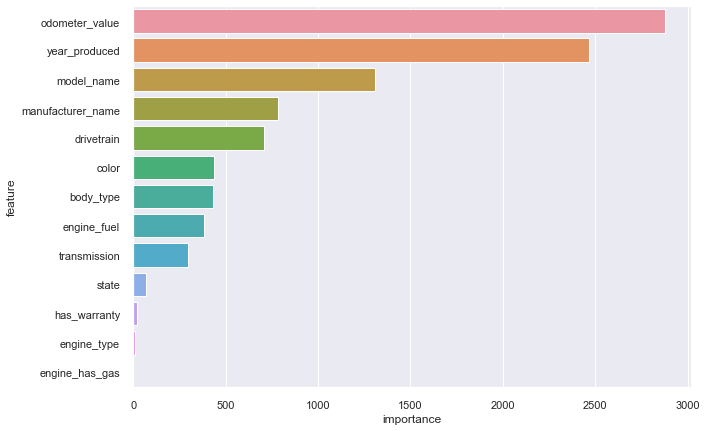

In [41]:
feat_imp = pd.DataFrame({'feature':X_train.columns, 'importance':lgbm_cv.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(y=feat_imp['feature'], x=feat_imp['importance'])

# 6. Shap

## 6a) General explainability

In [46]:
# Create object that can calculate SHAP values of the GridSearchCV model
explainer = shap.TreeExplainer(lgbm_cv)

# Calculate SHAP values based on X_train data (SHAP values are in USD, the same units as the target variable)
shap_values = explainer.shap_values(X)

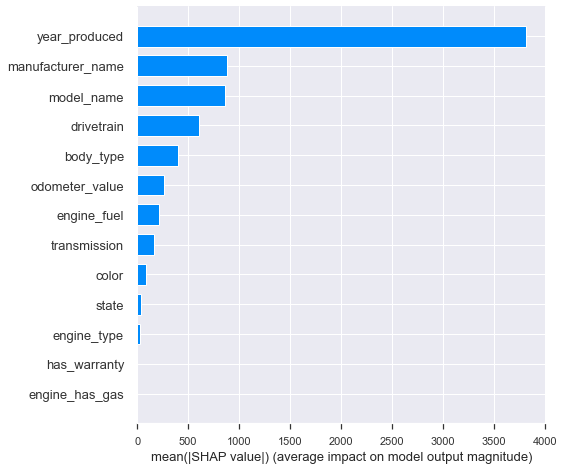

In [64]:
shap.summary_plot(shap_values, X, plot_type="bar")

# The "year_produced", i.e. the age, has by far the greatest contribution in predicting a car price 
# when combined by other features, followed by manufacturer and model. 
# On average, it can affect the price (either increasing or decreasing) by almost 4,000 USD.

# This also verifies the high correlation between year and price that was found previously.

# However, this plot is different than feature importance, because it shows the contribution of every 
# feature in USD (when making a prediction).

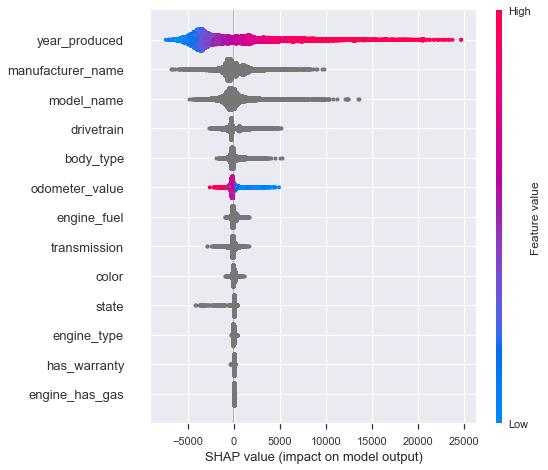

In [48]:
shap.summary_plot(shap_values, X)

# This works only for numerical features like year and odometer value:
# -> Red means high values of a feature (e.g. year=2020), while blue means small values (e.g. 1950).
# -> Distance from axis means magnitude of impact of this feature (how impactful/powerful is), 
# depending on high/small values.
# -> Side of axis is related to direction of prediction. When the feature values are on the right side, 
# the predicted value is higher. When on the left side, the predicted value is smaller.

# We see that regarding year, high (red) values (meaning recent years) have a higher impact on the 
# model output (far away from 0) and drive the price upwards (on the right of 0 axis, on the positive side).
# However, blue values (meaning years ago) don't have that much of an impact (not far from 0) and, 
# intuitively, are related to smaller prices (on the left, on the negative).

# On the other hand, high (red) odometer values (meaning more KMs) have a lot smaller impact on 
# model output (not so far away from 0) and decrease the price (on the left of 0 axis, on the negative side).

# These results are also in accordance to the correlation plots, so they are verified.

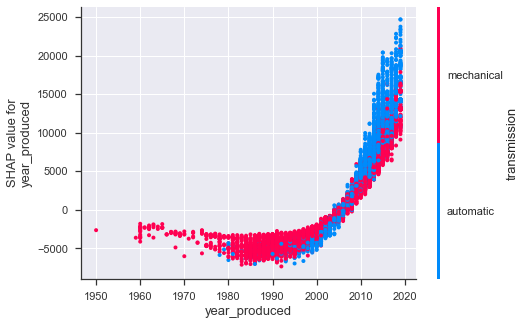

In [50]:
shap.dependence_plot('year_produced', shap_values, X)

# Here we see the interaction between a selected feature (year) and its most related one (according to 
# the SHAP algorithm, here is the transmission).

# Seems to be like the correlation plot between year and price and that makes sense. 
# But here we get another information:
# -> the impact of year is higher when the transmission is automatic, it results in a higher SHAP value. 

In [51]:
# the average value of the price in the train set (X_train)
explainer.expected_value

6605.6492151232815

In [52]:
# these are the Shapley values
shap_values

array([[ -385.36866406, -1293.44281724,  -105.10312536, ...,
         -422.55199549,   264.12922502,  -148.67992459],
       [  -28.35838272,  -119.08842499,   110.77476238, ...,
         -407.99610502, -2190.88486247,   -71.30590263],
       [ -199.06694452,  1081.1973823 ,  -126.83511246, ...,
         -574.55032971,  2412.75544857,   126.93031365],
       ...,
       [ -324.80840278,  -295.64662791,  -103.12193222, ...,
         -229.6983025 , -3708.45608979,  -155.16373899],
       [  839.18117586,   883.90222993,    40.26940509, ...,
          523.01453429, -5141.89558101,  -384.49069061],
       [ 3608.67452335,  1352.79585946,   946.55248751, ...,
        -1020.78047723, 18096.01904643,  1788.65305372]])

## 6b) Individual explainability

In [54]:
# Initialize:
shap.initjs()

# Specify case in the X_test to predict and see how every feature contributes to moving the 
# prediction from the (expected) average value to the final one:
row_to_predict = 0
data_for_prediction = X.iloc[[row_to_predict]]
prediction = lgbm.predict(data_for_prediction)[0]
print('prediction: ', prediction)

# Shap plot:
shap.force_plot(explainer.expected_value, shap_values[row_to_predict], data_for_prediction)

prediction:  4028.682383371788


In [55]:
data_for_prediction

,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,year_produced,odometer_value
0,Ford,Fusion,mechanical,blue,gasoline,False,gasoline,hatchback,False,owned,front,2006,245000


In [56]:
direction = 'up' if prediction > explainer.expected_value else 'down'
direction

'down'

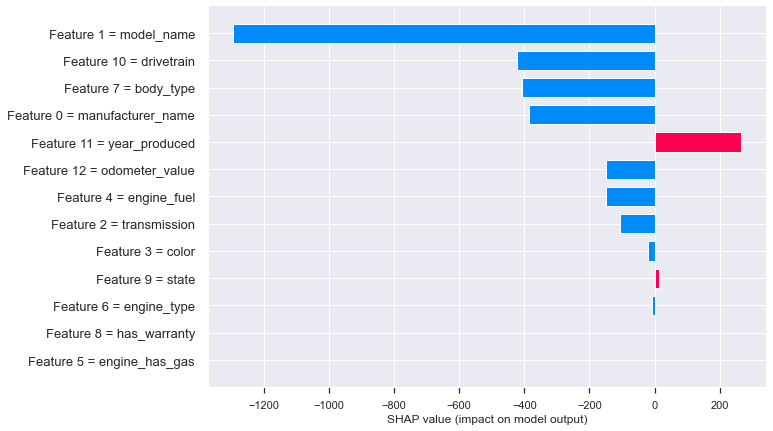

In [57]:
# Same but now in bar plot
fig = plt.figure(figsize=(10,7))
shap.bar_plot(shap_values[row_to_predict], data_for_prediction, max_display=20)

In [58]:
# Create a list with the Shap values for this case
original_sv = shap_values[row_to_predict].tolist()
sv = original_sv.copy()
if direction == 'up':
    sv = [i for i in sv if i>0]
else:
    sv = [i for i in sv if i<0]
    
    
# Get the absolute values of the list and reverse it. That way we see the "top" features, 
# no matter whether prediction is greater or smaller than the average value.
rev_sv = [abs(i) for i in sv].copy()
rev_sv.sort(reverse=True)

# Keep the top 4 shap values (contributions to the prediction) and find their positions in 
# the original list
max0 = rev_sv[0] if rev_sv[0] in sv else -rev_sv[0]
max1 = rev_sv[1] if rev_sv[1] in sv else -rev_sv[1]
max2 = rev_sv[2] if rev_sv[2] in sv else -rev_sv[2]
max3 = rev_sv[3] if rev_sv[3] in sv else -rev_sv[3]
print(max0, max1, max2, max3)

max0_index = original_sv.index(max0)
max1_index = original_sv.index(max1)
max2_index = original_sv.index(max2)
max3_index = original_sv.index(max3)
print(max0_index, max1_index, max2_index, max3_index)

# Identify the feature names and their values 
feat0 = ' '.join(data_for_prediction.columns[max0_index].split('_')).title()
feat1 = ' '.join(data_for_prediction.columns[max1_index].split('_')).title()
feat2 = ' '.join(data_for_prediction.columns[max2_index].split('_')).title()
feat3 = ' '.join(data_for_prediction.columns[max3_index].split('_')).title()

val0 = data_for_prediction.iloc[0,max0_index]
val1 = data_for_prediction.iloc[0,max1_index]
val2 = data_for_prediction.iloc[0,max2_index]
val3 = data_for_prediction.iloc[0,max3_index]

-1293.4428172425696 -422.55199548525263 -406.19899485215774 -385.368664061194
1 10 7 0


In [62]:
print('The average price is ', explainer.expected_value, '.\n')
print('The predicted price is driven ', direction, ' mainly because:', 
     '\n\t a)', feat0, 'is', val0, 'and affects the price by', round(max0,2), '$',
     '\n\t b)', feat1, 'is', val1, 'and affects the price by', round(max1,2), '$',
     '\n\t c)', feat2, 'is', val2, 'and affects the price by', round(max2,2), '$',
     '\n\t d)', feat3, 'is', val3, 'and affects the price by', round(max3,2), '$',
     )

The average price is  6605.6492151232815 .

The predicted price is driven  down  mainly because: 
	 a) Model Name is Fusion and affects the price by -1293.44 $ 
	 b) Drivetrain is front and affects the price by -422.55 $ 
	 c) Body Type is hatchback and affects the price by -406.2 $ 
	 d) Manufacturer Name is Ford and affects the price by -385.37 $


# 7. Save objects

In [65]:
import pickle


with open('dataset.pickle', 'wb') as handle:
    pickle.dump(df, handle)
    
    
with open('lgbm_cv.pickle', 'wb') as handle:
    pickle.dump(lgbm_cv, handle)
    
    
with open('explainer.pickle', 'wb') as handle:
    pickle.dump(explainer, handle)
    
    
with open('shap_values.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle)